In [1]:
%%file BS_Vanilla_Greeks.m
%European Vanilla Option Greeks (분석적 방법)

function result = BS_Vanilla_Greeks(C_P, Greeks, S, X, r, T, vol, q)

%d1, d2계산
d1 = (log(S/X) + (r-q + vol^2/2)*T) / (vol*sqrt(T));
d2 = d1 - vol*sqrt(T);

%옵션 가격 및 민감도 계산
%(N'(d1) : Normal Probability density function, mu=0, sigma=1)
if C_P == 'C'
    switch Greeks
        case 'price'
            result = S * exp(-q*T) * normcdf(d1) - X*exp(-r*T) * normcdf(d2);
        case 'delta'
            result = normcdf(d1) * exp(-q*T);
        case 'gamma'
            % N'(d1), Normpdf 함수 사용
            result = (normpdf(d1) * exp(-q*T)) / (S*vol*sqrt(T));
        case 'vega'
            result = S * sqrt(T) * normpdf(d1) * exp(-q *T);
        case 'theta'
            result = (-S * normpdf(d1) * vol * exp(-q*T)) / (2 * sqrt(T)) + q * S * normcdf(d1) * exp(-q*T)...
                      - r * X * exp(-r*T) * normcdf(d2);
        case 'rho'
            result = normcdf(d2) * X * T * exp(-r*T);
    end
elseif C_P == 'P'
    switch Greeks
        case 'price'
            result = -S * exp(-q*T) * normcdf(-d1) + X * exp(-r*T) * normcdf(-d2);
        case 'delta'
            result = (normcdf(d1) -1) * exp(-q*T);
        case 'gamma'
            result = (normpdf(d1) * exp(-q*T)) / (S*vol*sqrt(T));
        case 'vega'
            result = S * sqrt(T) * normpdf(d1) * exp(-q *T);
        case 'theta'
            result = (-S * normpdf(d1) * vol * exp(-q*T)) / (2 * sqrt(T)) - q * S * normcdf(-d1) * exp(-q*T)...
                      + r * X * exp(-r*T) * normcdf(-d2);
        case 'rho'
            result = -normcdf(-d2) * X * T * exp(-r*T);
    end
end

Created file '/Users/changsoo/Desktop/논문/Matlab/BS_Vanilla_Greeks.m'.


In [2]:
C_P = 'C'; S = 100; X = 100; r=0.05; T=0.5; vol=0.3; q = 0.01;

In [3]:
Call_Delta = BS_Vanilla_Greeks(C_P, 'delta', S, X, r, T, vol, q)


Call_Delta =

    0.5765



In [4]:
Call_Gamma = BS_Vanilla_Greeks(C_P, 'gamma', S, X, r, T, vol, q)


Call_Gamma =

    0.0183



In [5]:
Call_Vega = BS_Vanilla_Greeks(C_P, 'vega', S, X, r, T, vol, q)


Call_Vega =

   27.5111



In [6]:
Call_Theta = BS_Vanilla_Greeks(C_P, 'theta', S, X, r, T, vol, q)


Call_Theta =

  -10.0922



In [7]:
Call_Rho = BS_Vanilla_Greeks(C_P, 'rho', S, X, r, T, vol, q)


Call_Rho =

   24.1535



In [8]:
%%file MC_Vanilla_Greeks.m
%European Vanilla Option Greeks(MC, 근사적방법)

function result = MC_Vanilla_Greeks(C_P, Greeks, S_tick, S0, X, r, T, vol_tick, vol, q, N, ns)

    dt = T/N;
    
    %S up, down
    SU  = S0 + S_tick;
    SD  = S0 - S_tick;
    SP0 = zeros(ns, N+1);
    SP0(:, 1) = S0;
    SPU = zeros(ns, N+1);
    SPU(:, 1) = SU;
    SPD = zeros(ns, N+1);
    SPD(:, 1) = SD;
    
    %vol up
    volU    = vol + vol_tick;
    SP_volU = zeros(ns, N+1);
    SP_volU(:, 1) = S0;
    
    %stock process
    for i=1:ns
        w = randn(N, 1);
        for j=2:N+1
            SP0(i, j)     = SP0(i, j-1) * exp((r-q-vol^2/2) * dt + vol * sqrt(dt) * w(j-1));
            SPU(i, j)     = SPU(i, j-1) * exp((r-q-vol^2/2) * dt + vol * sqrt(dt) * w(j-1));
            SPD(i, j)     = SPD(i, j-1) * exp((r-q-vol^2/2) * dt + vol * sqrt(dt) * w(j-1));
            SP_volU(i, j) = SP_volU(i, j-1) * exp((r-q-volU^2/2) * dt + volU * sqrt(dt) * w(j-1));
        end
    end
    
    %각 상황별 payoffs 계산
    if C_P == 'C'
        payoff0     = max(SP0(:, N+1) - X, 0);
        payoffU     = max(SPU(:, N+1) - X, 0);
        payoffD     = max(SPD(:, N+1) - X, 0);
        payoff_volU = max(SP_volU(:, N+1) - X, 0);
    else
        payoff0     = max(X - SP0(:, N+1), 0);
        payoffU     = max(X - SPU(:, N+1), 0);
        payoffD     = max(X - SPD(:, N+1), 0);
        payoff_volU = max(X - SP_volU(:, N+1), 0);
    end
        
    %각 상황별 price 계산
    V0 = exp(-r*T) * mean(payoff0);
    VU = exp(-r*T) * mean(payoffU);
    VD = exp(-r*T) * mean(payoffD);
    V_volU = exp(-r*T) * mean(payoff_volU);
    
    %Greeks 계산
    switch Greeks
        case 'price'
            result = V0;
        case 'delta'
            result = (VU-VD) / (SU-SD);
        case 'gamma'
            result = ((VU-V0) / (SU-S0) - (V0-VD)/(S0-SD)) / (0.5*(SU-SD));
        case 'vega'
            result = (V_volU - V0) / vol_tick;
    end
        

Created file '/Users/changsoo/Desktop/논문/Matlab/MC_Vanilla_Greeks.m'.


In [9]:
C_P = 'C'; S_tick = 2; S0 = 100; X = 100; r=0.05; T=0.5; vol_tick=0.01; vol=0.3; q = 0.01; N= 1; ns=1000000;

In [10]:
Call_Delta = MC_Vanilla_Greeks(C_P, 'delta', S_tick, S0, X, r, T, vol_tick, vol, q, N, ns)


Call_Delta =

    0.5767



In [11]:
Call_Gamma = MC_Vanilla_Greeks(C_P, 'gamma', S_tick, S0, X, r, T, vol_tick, vol, q, N, ns)


Call_Gamma =

    0.0183



In [12]:
Call_Vega = MC_Vanilla_Greeks(C_P, 'vega', S_tick, S0, X, r, T, vol_tick, vol, q, N, ns)


Call_Vega =

   27.4497




HC_ave =

  963.3935


HC_Var =

   50.8363


CI =

  960.2388
  966.5481


SE =

    1.6076



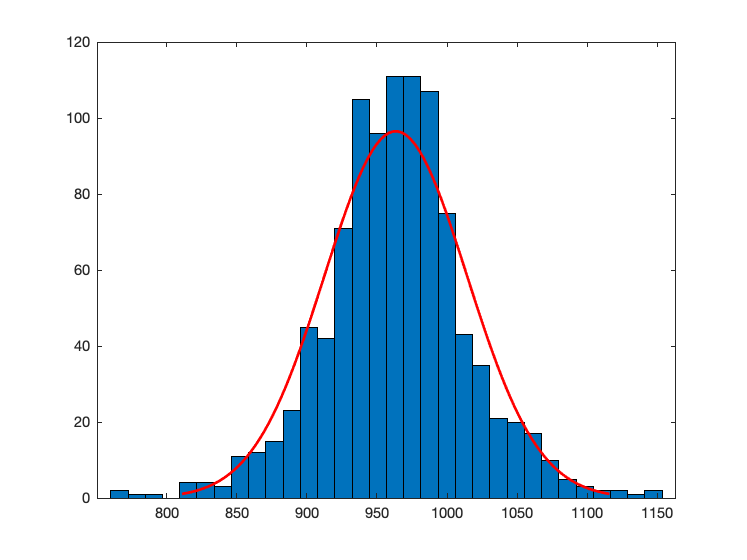

In [13]:
%European Vanilla Call Option Dynamic Delta Hedging

%기초변수 입력, ns : 헤징 시뮬레이션 횟수
S0 = 100; X = 100; r = 0.05; T = 0.5; vol = 0.3; ns = 1000; ON = 100; rebalance = 'd';
if rebalance == 'w'
    N = round(T*52);
elseif rebalance == 'd'
    N = round(T*365);
end

tau = T/N;

%배열생성
S     = zeros(ns, N+1);         %주가
delta = zeros(ns, N+1);         %단위델타
D     = zeros(ns, N+1);         %수량델타
reb   = zeros(ns, N+1);         %주식매매금액
B     = zeros(ns, N+1);         %이자비용
C     = zeros(ns, N+1);         %누적비용

%배열초기값 Setting
S(:, 1)     = S0;
delta(:, 1) = blsdelta(S0, X, r, T, vol);
D(:, 1)     = delta(:, 1) * ON;
reb(:, 1)   = D(:, 1) * S0;
C(:, 1)     = reb(:, 1);
B(:, 1)     = 0;

%헤징 시뮬레이션 실행
for i=1:ns
    w = randn(N, 1);
    for j=2:N+1
        %주가프로세스 생성
        S(i, j) = S(i, j-1) * exp((r-vol^2/2) * tau + vol * sqrt(tau) * w(j-1, 1));
        if j == N+1
            if S(i, j) >= X
                delta(i, j) = 1;
            else
                delta(i, j) = 0;
            end
        else
            %각 시점별 단위델타 계산
            delta(i, j) = blsdelta(S(i, j), X, r, T-(j-1)*tau, vol);
        end
        
        %각 배열값 계산
        D(i, j)   = delta(i, j) * ON;
        reb(i, j) = (D(i, j) - D(i, j-1)) * S(i, j);
        B(i, j)   = (exp(r*tau)-1) * C(i, j-1);
        C(i, j)   = C(i, j-1) + reb(i, j) + B(i, j);
    end
end

%헤지비용 계산
BS_Call = blsprice(S0, X, r, T, vol) * ON;
SP = S(:, end) .* D(:, end);
OP = max(S(:, end) - X, 0) * ON;
HC = exp(-r*T) * (C(:, end) - SP + OP);
[HC_ave, HC_Var, CI] = normfit(HC)
SE = HC_Var / sqrt(ns)
histfit(HC)
        

In [14]:
%%file Vol_fun.m
function f = Vol_fun(a, X)
    f = a(1) + a(2) * X + a(3) * X.^2;

Created file '/Users/changsoo/Desktop/논문/Matlab/Vol_fun.m'.


In [24]:
%Smile Adjusted Delta

%기초변수 입력
S=194.59; r=0.0495; q=0; T=21/365;

%Smile Adjusted Delta(Call)
market_data = csvread('Call_data.csv');
temp_size   = size(market_data);
CX          = market_data(:, 1);         %행사가격
CP          = market_data(:, 2);         %시장가격
C_ImpVol    = zeros(temp_size(1), 1);    %콜옵션 내재변동성 초기화
for i =1:temp_size(1)
    C_ImpVol(i) = Newton_ImpVol('C', S, CX(i), r, T, q, CP(i));
end

Ca   = lsqcurvefit(@Vol_fun, [0.01 0.01 0.01], CX, C_ImpVol);
C_dX = Ca(2) + 2 * Ca(3) * CX;

%블랙숄즈 델타
C_BSD = BS_Vanilla_Greeks('C', 'delta', S, CX, r, T, C_ImpVol, q);

%블랙숄즈 베가
C_BSV = BS_Vanilla_Greeks('C', 'vega', S, CX, r, T, C_ImpVol, q);

C_SAD = C_BSD + C_BSV.*C_dX;

%Smile Adjusted Delta(Put)
market_data = csvread('Put_data.csv');
temp_size   = size(market_data);
PX          = market_data(:, 1);
PP          = market_data(:, 2);

P_ImpVol = zeros(temp_size(1), 1);
for i=1:temp_size(1)
    P_ImpVol(i) = Newton_ImpVol('P', S, PX(i), r, T, q, PP(i));
end

Pa    = lsqcurvefit(@Vol_fun, [0.01 0.01 0.01], PX, P_ImpVol);
P_dX  = Pa(2) + 2 * Pa(3) * PX;
P_BSD = BS_Vanilla_Greeks('P', 'delta', S, PX, r, T, P_ImpVol, q);
P_BSV = BS_Vanilla_Greeks('P', 'vega',  S, PX, r, T, P_ImpVol, q);
P_SAD = P_BSD + P_BSV .* P_dX;


국소 최솟값을 찾았습니다.

기울기의 크기가 최적성 허용오차의
값보다 작기 때문에 최적화가 완료되었습니다.


국소 최솟값을 찾았습니다.

기울기의 크기가 최적성 허용오차의
값보다 작기 때문에 최적화가 완료되었습니다.



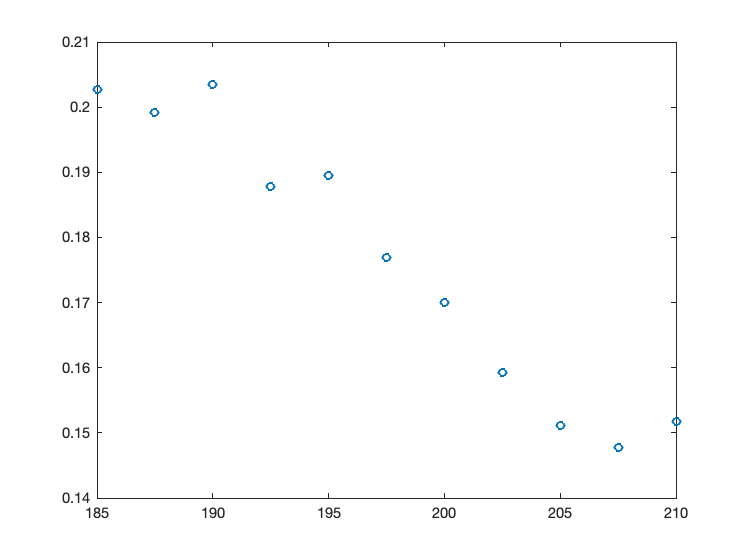

In [27]:
plot(CX, C_ImpVol, 'o')

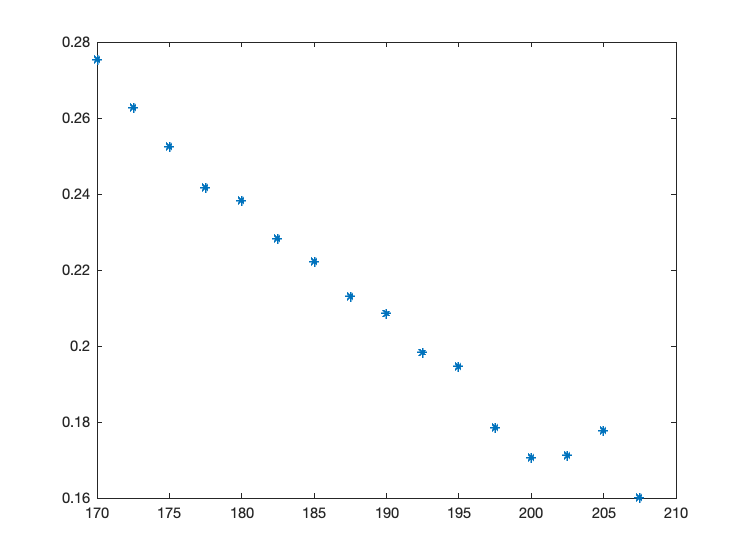

In [28]:
plot(PX, P_ImpVol, '*')

In [36]:
[CX C_BSD C_SAD C_BSD-C_SAD]


ans =

  185.0000    0.8692    0.8462    0.0230
  187.5000    0.8052    0.7748    0.0303
  190.0000    0.7163    0.6783    0.0379
  192.5000    0.6276    0.5845    0.0431
  195.0000    0.5156    0.4694    0.0462
  197.5000    0.3968    0.3514    0.0454
  200.0000    0.2803    0.2400    0.0403
  202.5000    0.1713    0.1404    0.0309
  205.0000    0.0900    0.0700    0.0200
  207.5000    0.0432    0.0317    0.0115
  210.0000    0.0229    0.0160    0.0069



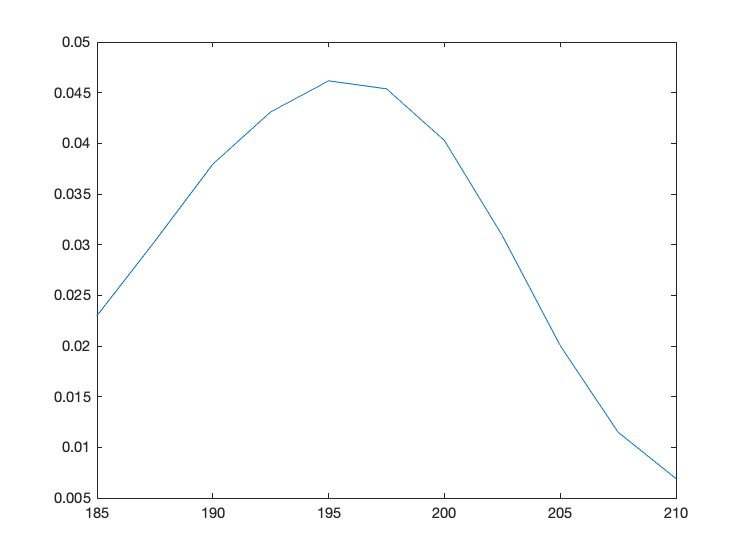

In [38]:
plot(CX, C_BSD-C_SAD)

In [37]:
[PX P_BSD P_SAD P_BSD-P_SAD]


ans =

  170.0000   -0.0169   -0.0247    0.0078
  172.5000   -0.0234   -0.0333    0.0099
  175.0000   -0.0337   -0.0467    0.0129
  177.5000   -0.0481   -0.0647    0.0166
  180.0000   -0.0746   -0.0972    0.0226
  182.5000   -0.1054   -0.1335    0.0280
  185.0000   -0.1520   -0.1867    0.0347
  187.5000   -0.2097   -0.2504    0.0407
  190.0000   -0.2880   -0.3341    0.0460
  192.5000   -0.3781   -0.4270    0.0489
  195.0000   -0.4843   -0.5332    0.0488
  197.5000   -0.6020   -0.6469    0.0448
  200.0000   -0.7190   -0.7561    0.0371
  202.5000   -0.8107   -0.8388    0.0281
  205.0000   -0.8715   -0.8920    0.0204
  207.5000   -0.9428   -0.9532    0.0105



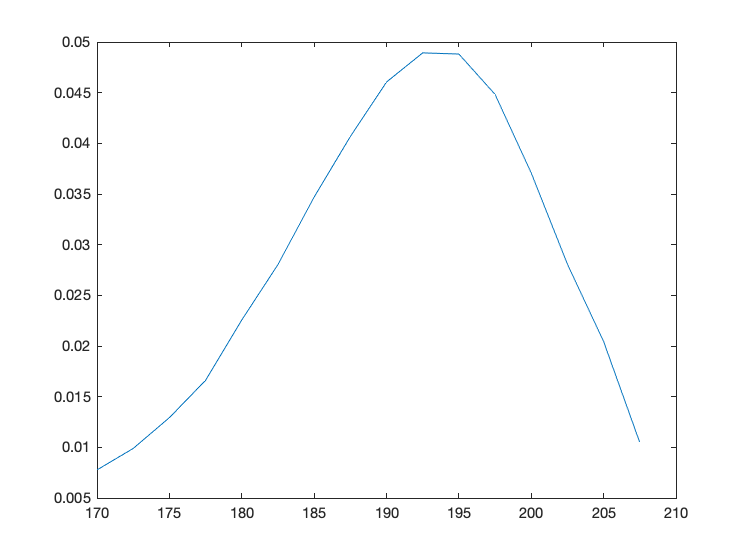

In [39]:
plot(PX, P_BSD-P_SAD)

In [56]:
%%file Trinomial_Vanilla_Greeks.m
%European/American Vanilla Option Greeks (Trinomial Tree, 근사)

function result = Trinomial_Vanilla_Greeks(Style, C_P, Greeks, S, X, r, T, vol, q, N)
    dt = T / N;
    
    %주가, 파생상품가격 트리 생성
    [p, f_tree, S_tree] = Trinomial_Vanilla_Tree(Style, C_P, S, X, r, T, vol, q, N);
    
    %상승, 하락, 유지시 주가 및 파생상품가격 초기화
    SU = S_tree(N, 2);
    S0 = S_tree(N+1, 2);
    SD = S_tree(N+2, 2);
    VU = f_tree(N, 2);
    V0 = f_tree(N+1, 2);
    VD = f_tree(N+2, 2);
    
    %상승변동성(1%상승) 시 파생상품가격
    VvolU = Trinomial_Vanilla_Tree(Style, C_P, S, X, r, T, vol+0.01, q, N);
    
    %Greeks 계산
    switch Greeks
        case 'price'
            result = p;
        case 'delta'
            result = (VU-VD) / (SU-SD);
        case 'gamma'
            result = ((VU-V0) / (SU-S0) - (V0 - VD) / (S0 - SD)) / (0.5 * (SU - SD));
        case 'vega'
            result = (VvolU - p) / 0.01;
        case 'theta'
            result = (V0 - p) / dt;
    end

Created file '/Users/changsoo/Desktop/논문/Matlab/Trinomial_Vanilla_Greeks.m'.


In [57]:
Trinomial_Vanilla_Greeks('AM', 'P', 'delta', 100, 100, 0.05, 0.5, 0.3, 0.01, 1000)


ans =

   -0.4335



In [58]:
Trinomial_Vanilla_Greeks('AM', 'P', 'gamma', 100, 100, 0.05, 0.5, 0.3, 0.01, 1000)


ans =

    0.0195



In [59]:
Trinomial_Vanilla_Greeks('AM', 'P', 'vega', 100, 100, 0.05, 0.5, 0.3, 0.01, 1000)


ans =

   27.5004



In [60]:
Trinomial_Vanilla_Greeks('AM', 'P', 'theta', 100, 100, 0.05, 0.5, 0.3, 0.01, 1000)


ans =

   -6.6624



In [61]:
%%file Trinomial_KnockOut_Greeks.m
%European/American KnockOut Option Greeks (Trinomial Tree, 근사)

function result = Trinomial_KnockOut_Greeks(Style, C_P, Greeks, S, X, r, T, vol, KO, barrier, q, N)
    dt = T / N;
    
    %주가, 파생상품가격 트리 생성
    [p, f_tree, S_tree] = Trinomial_KnockOut_Tree(Style, C_P, S, X, r, T, vol, KO, barrier, q, N);
    
    %상승, 하락, 유지시 주가 및 파생상품가격 초기화
    SU = S_tree(N, 2);
    S0 = S_tree(N+1, 2);
    SD = S_tree(N+2, 2);
    VU = f_tree(N, 2);
    V0 = f_tree(N+1, 2);
    VD = f_tree(N+2, 2);
    
    %상승변동성(1%상승) 시 파생상품가격
    VvolU = Trinomial_KnockOut_Tree(Style, C_P, S, X, r, T, vol+0.01, KO, barrier, q, N);
    
    %Greeks 계산
    switch Greeks
        case 'price'
            result = p;
        case 'delta'
            result = (VU-VD) / (SU-SD);
        case 'gamma'
            result = ((VU-V0) / (SU-S0) - (V0 - VD) / (S0 - SD)) / (0.5 * (SU - SD));
        case 'vega'
            result = (VvolU - p) / 0.01;
        case 'theta'
            result = (V0 - p) / dt;
    end

Created file '/Users/changsoo/Desktop/논문/Matlab/Trinomial_KnockOut_Greeks.m'.


In [62]:
Trinomial_KnockOut_Greeks('EU', 'C', 'delta', 100, 100, 0.05, 0.5, 0.3, 'U', 130, 0.01, 1000)


ans =

    0.0296



In [63]:
Trinomial_KnockOut_Greeks('EU', 'C', 'delta', 100, 100, 0.05, 0.5, 0.3, 'U', 130, 0.01, 3000)


ans =

    0.0364



In [64]:
Trinomial_KnockOut_Greeks('EU', 'C', 'gamma', 100, 100, 0.05, 0.5, 0.3, 'U', 130, 0.01, 1000)


ans =

   -0.0092



In [65]:
Trinomial_KnockOut_Greeks('EU', 'C', 'vega', 100, 100, 0.05, 0.5, 0.3, 'U', 130, 0.01, 1000)


ans =

  -14.6822

